In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pywaffle import Waffle  # pip install pywaffle

%matplotlib inline

In [3]:
dtypes_auc = { "auction_type_id": np.float16, "country": "category", "platform": "category", "ref_type_id": "category", 
               "source_id": "category", "device_id": "category"}

In [4]:
auctions = pd.read_csv('data/auctions.csv.gzip', compression = 'gzip', low_memory = False, dtype=dtypes_auc)

In [5]:
auctions['date'] = pd.to_datetime(auctions['date'])

## **Analisis inicial**

In [6]:
auctions.head()

,auction_type_id,country,date,device_id,platform,ref_type_id,source_id
0,NaN,6333597102633388268,2019-03-11 14:18:33.290763,6059599345986491085,1,1,0
1,NaN,6333597102633388268,2019-03-11 14:18:34.440157,1115994996230693426,1,1,0
2,NaN,6333597102633388268,2019-03-11 14:18:35.862360,7463856250762200923,1,1,0
3,NaN,6333597102633388268,2019-03-11 14:18:36.167163,7829815350267792040,1,1,0
4,NaN,6333597102633388268,2019-03-11 14:18:37.728590,1448534231953777480,1,1,0


In [7]:
len(auctions)

19571319

In [8]:
auctions['auction_type_id'].isnull().sum()
# Auction Type ID es todo Null #

19571319

In [53]:
auctions['platform'].value_counts()

1    15541825
2     4029494
Name: platform, dtype: int64

In [55]:
auctions['country'].value_counts()

6333597102633388268    19571319
Name: country, dtype: int64

In [56]:
auctions['ref_type_id'].value_counts()

1    15541825
7     4029494
Name: ref_type_id, dtype: int64

In [66]:
auctions.groupby(['platform', 'ref_type_id']).agg({'platform' : 'count'})

,,platform
platform,ref_type_id,
1,1,15541825
2,7,4029494


## 1 - Cantidad auctions por dia de los 5 devices mas populares

In [10]:
auctions['device_id'].value_counts().head(5)

633139769114048761     27762
7202276635029175071    23055
7298861376107043945    18188
6302840482782120473    16400
5376802567578262905    16367
Name: device_id, dtype: int64

In [11]:
#Quiero tener algun tipo de indice para no hardcodear los valores de los id's
top5 = auctions.groupby('device_id').agg({'device_id': 'count'})

In [12]:
top5.columns = ['count']

In [13]:
top5 = top5.sort_values('count', ascending = False).head(5)

In [14]:
top5.reset_index(inplace = True)

In [15]:
top5

,device_id,count
0,633139769114048761,27762
1,7202276635029175071,23055
2,7298861376107043945,18188
3,6302840482782120473,16400
4,5376802567578262905,16367


In [16]:
auctions['day'] = auctions['date'].dt.day

In [49]:
auctions_graficable = auctions.loc[(auctions['device_id'] == top5.loc[0,'device_id']) | (auctions['device_id'] == top5.loc[1,'device_id']) | \
             (auctions['device_id'] == top5.loc[2,'device_id']) | (auctions['device_id'] == top5.loc[3,'device_id']) | \
             (auctions['device_id'] == top5.loc[4,'device_id']) ]\
        .groupby(['day','platform']).agg({'day' : 'count'})

In [50]:
auctions_graficable.columns = ['count']

In [51]:
auctions_graficable.reset_index(inplace = True)

In [52]:
auctions_graficable.head()

,day,platform,count
0,5,1,3896
1,6,1,2136
2,7,1,9370
3,8,1,11177
4,9,1,11422


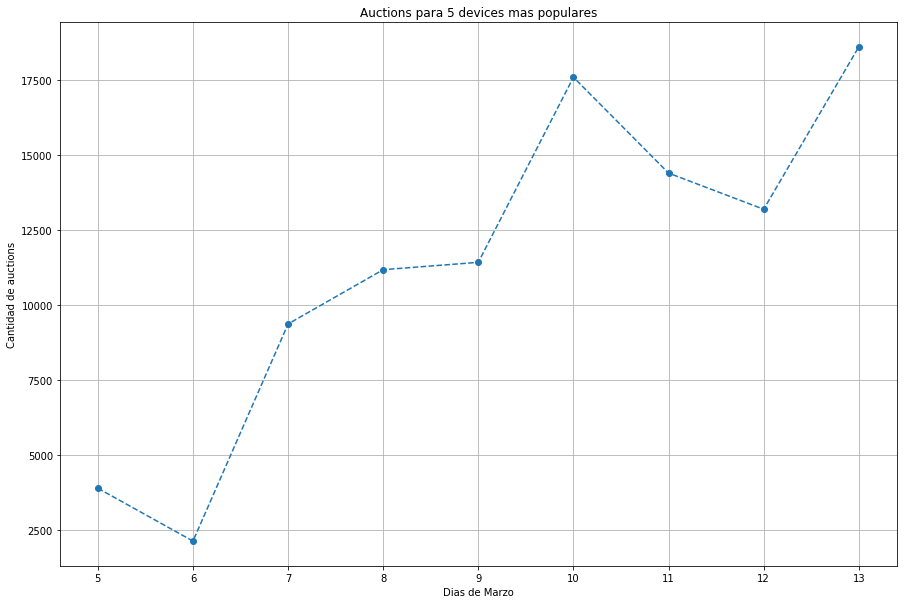

In [54]:
grph1 = auctions_graficable.plot.line('day', 'count', grid = True, figsize = (15,10), style = 'o--', rot = 0, legend =False, title = 'Auctions para 5 devices mas populares')
grph1.set_xlabel('Dias de Marzo')
grph1.set_ylabel('Cantidad de auctions');

## 2 - Cantidad de auctions por source

In [22]:
auctions['source_id'].value_counts()

0    13354597
1     4016739
5     1466494
2      582083
6      151406
Name: source_id, dtype: int64

In [23]:
auctions_source = auctions.groupby('source_id').agg({'source_id' : 'count'})

In [24]:
auctions_source.columns = ['count']

In [25]:
auctions_source.reset_index(inplace = True)

In [26]:
auctions_source = auctions_source.sort_values('count', ascending = False)

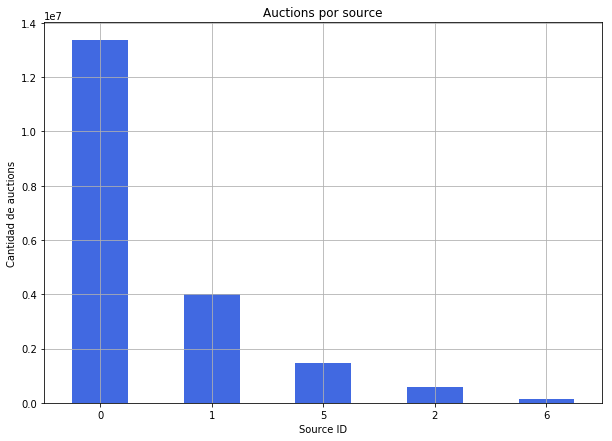

In [27]:
grph3 = auctions_source.plot.bar('source_id', 'count', grid = True, figsize = (10,7), color = 'royalblue', legend = False, rot = 0, title = 'Auctions por source')
grph3.set_ylabel('Cantidad de auctions')
grph3.set_xlabel('Source ID');

## 3 - Cantidad de auctions segun la hora de cada dia

Se quiere saber cual es la hora donde suceden mas subastas

In [28]:
auctions['hour'] = auctions['date'].dt.hour

In [29]:
tiempo = auctions.groupby(['day', 'hour']).agg({'hour' : 'count'})
tiempo = tiempo.rename(columns = {'hour':'auction_count'})
tiempo = tiempo.reset_index()
tiempo.head()

,day,hour,auction_count
0,5,0,14859
1,5,1,174893
2,5,2,155339
3,5,3,108498
4,5,4,74230


Text(123.0, 0.5, 'Días')

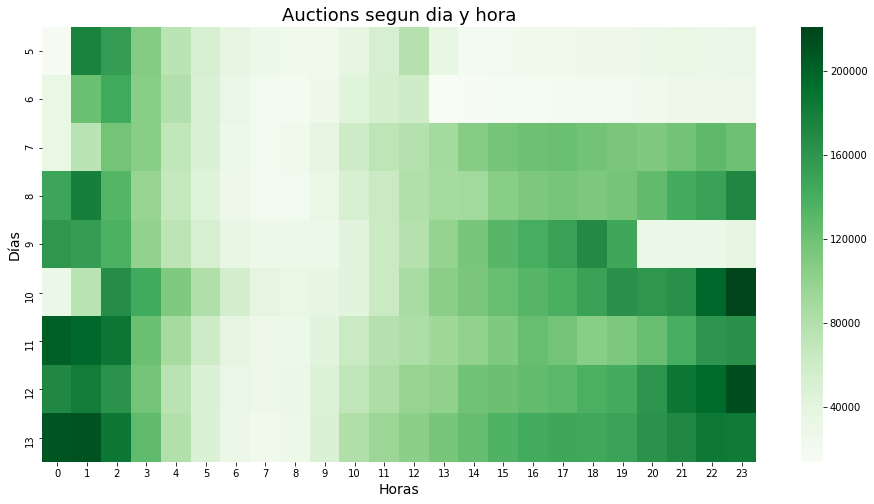

In [30]:
plt.figure(figsize = (16,8))
tiempo_graf = tiempo.pivot_table(index='day', columns='hour', values='auction_count')
heatMap = sns.heatmap(tiempo_graf,  cmap="Greens", )
heatMap.set_title("Auctions segun dia y hora", fontsize = 18)
heatMap.set_xlabel("Horas", fontsize = 14)
heatMap.set_ylabel("Días", fontsize = 14)

## 4- Tiempo entre aparicion de un dispositivo en una subasta y el click

### Se quiere saber, para cada dispositivo, el tiempo entre su primera aparicion en la subasta y su primer click en la publicidad, y asi obtener conclusiones

In [3]:
dtypes_clk = { "advertiser_id": np.int8, "action_id": np.float16, "source_id": np.int8, "country_code": "category", 
               "latitude": np.float16, "longitude": np.float16, "wifi_connection": "category", "carrier_id": np.float16,
               "trans_id": "object", "os_major":np.float32, "brand": np.float16, "touchX": np.float16,
               "touchY": np.float16}
clicks = pd.read_csv('data/clicks.csv.gzip', compression = 'gzip', low_memory = False, dtype=dtypes_clk)

In [4]:
clicks.head()

,advertiser_id,action_id,source_id,created,country_code,latitude,longitude,wifi_connection,carrier_id,trans_id,os_minor,agent_device,os_major,specs_brand,brand,timeToClick,touchX,touchY,ref_type,ref_hash
0,2,NaN,4,2019-03-06T22:42:12.755Z,6333597102633388268,1.206055,1.070312,False,1.0,iGgClCM9exiHF4K31g94XmvHEBSLKIY,6.768137e+18,NaN,3.072849e+18,2733035977666442898,NaN,1.563,0.904785,0.078003,1891515180541284343,1904083516767779093
1,0,NaN,0,2019-03-08T10:24:30.641Z,6333597102633388268,1.218750,1.071289,False,4.0,MMHTOJ6qKAOeIH_Eywh1KIcCaxtO9oM,3.025219e+18,NaN,1.774085e+18,392184377613098015,NaN,NaN,NaN,NaN,1891515180541284343,3086509764961796666
2,0,NaN,0,2019-03-08T15:24:16.069Z,6333597102633388268,1.206055,1.070312,False,6.0,vIrEIdf9izUaWdAri6Ezk7T3nHFvNQU,5.975656e+18,NaN,3.072849e+18,392184377613098015,NaN,NaN,0.945801,0.472900,1891515180541284343,6958163894863846647
3,2,NaN,3,2019-03-06T03:08:51.543Z,6333597102633388268,1.206055,1.070312,False,45.0,YaKxxEAs2UmZhSpRfiCO9Zpa82B_AKM,6.768137e+18,NaN,3.072849e+18,2733035977666442898,NaN,19.013,0.035004,0.430908,1891515180541284343,4368617728156436525
4,2,NaN,3,2019-03-06T03:32:55.570Z,6333597102633388268,1.206055,1.070312,False,45.0,X5XTOcYQovkl6yadYdAD7xioVGU9jiY,6.768137e+18,NaN,3.072849e+18,2733035977666442898,NaN,28.110,0.053986,0.423096,1891515180541284343,4368617728156436525


In [5]:
seccion_clicks = clicks[['created','ref_hash']]
#seccion_auctions = auctions[['date','device_id']]
seccion_auctions = pd.read_csv('data/auctions.csv.gzip', usecols = ["date", "device_id"], compression = 'gzip')

In [6]:
seccion_clicks.created = pd.to_datetime(seccion_clicks.created)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [7]:
seccion_auctions.date = pd.to_datetime(seccion_auctions.date)

In [8]:
primeros_clicks = seccion_clicks.groupby('ref_hash').agg({'created':'min'}).reset_index()

In [9]:
primeras_apariciones_subasta = seccion_auctions.groupby('device_id').agg({'date':'min'}).reset_index()

In [61]:
merged = primeros_clicks.merge(primeras_apariciones_subasta, left_on='ref_hash', right_on='device_id', how='inner')
merged.head()

,ref_hash,created,device_id,date
0,928619179373370,2019-03-10 02:01:03.902,928619179373370,2019-03-05 11:40:26.288521
1,1114666473184120,2019-03-12 15:54:16.857,1114666473184120,2019-03-05 01:43:10.409186
2,1178663993884805,2019-03-07 23:16:11.813,1178663993884805,2019-03-05 01:39:36.948146
3,1360619548394952,2019-03-07 23:08:02.170,1360619548394952,2019-03-05 01:51:47.288540
4,1496749780481786,2019-03-07 23:17:51.372,1496749780481786,2019-03-05 03:07:42.327940


In [62]:
merged = merged.drop(columns=['ref_hash']) #Repetida, la saco

In [63]:
merged = merged.rename(columns={'created':'click_time','date':'auction_time'})

In [64]:
merged['auction_day'] = merged['auction_time'].dt.day
merged['click_day'] = merged['click_time'].dt.day

In [65]:
merged = merged.drop(columns=['auction_time', 'click_time'])

In [66]:
merged['days_to_click'] = merged['click_day'] - merged['auction_day']

In [70]:
merged.days_to_click.mean()

3.570410507097002

In [71]:
merged.days_to_click.std()

2.337378719129253

# **FALTA: Grafico para ver el tiempo que pasa entre una cosa y la otra**

## 5 - Cantidad de auctions por hora

In [98]:
auct_hora = auctions.groupby('hour').agg({'hour':'count'})

In [99]:
auct_hora.columns = ['count']

In [100]:
from math import pi

labels = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23])
angles = [i / float(24) * 2 * pi for i in range(24)]
angles += angles[:1]  #cerrar el círculo

Text(0.5, 1.08, 'Cantidad por hora')

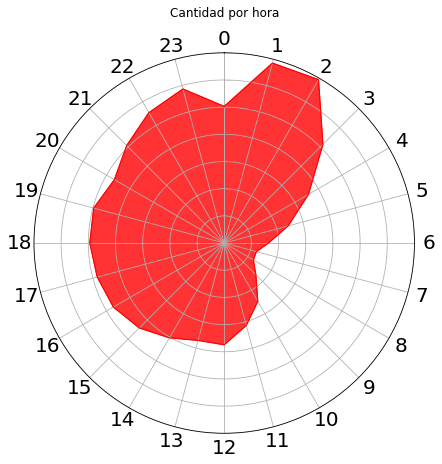

In [102]:
fig=plt.figure(figsize=(7,7))
series = plt.subplot(111, polar=True)
    
series.set_theta_offset(pi / 2)
series.set_theta_direction(-1)

plt.xticks(angles, labels, color='#000000', size=20)

plt.yticks([200000, 400000, 600000, 800000, 1000000, 1200000, 1400000], ['200000', '400000', '600000', '800000', '1000000', '1200000', '1400000'], color='#999999', size=2)
plt.ylim(0,1400000)

horas = auct_hora['count'].tolist()
horas += horas[:1]

series.set_rlabel_position(0)
series.plot(angles, horas, color='#FF0000', linestyle='solid', linewidth=1)
series.fill(angles, horas, color='#FF0000', alpha=0.8)
series.set_title('Cantidad por hora', y=1.08)

## 6 - Cantidad de auctions por dia

In [46]:
auct_dia = auctions.groupby('day').agg({'day':'count'})

In [47]:
auct_dia.columns = ['count']

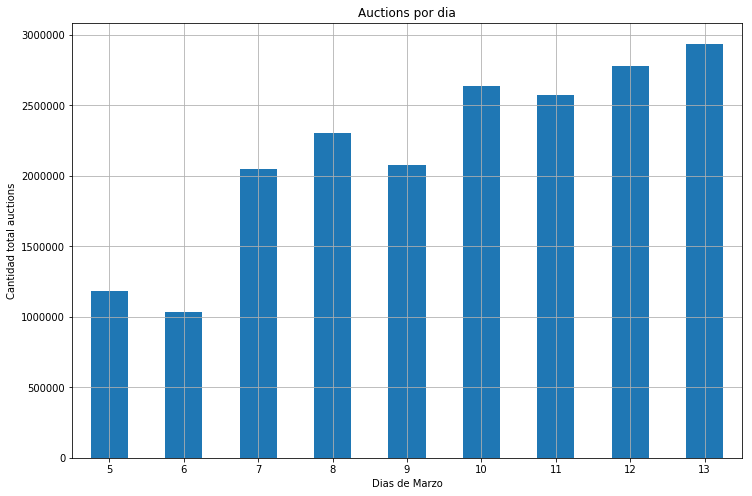

In [48]:
grph6 = auct_dia.plot.bar(figsize = (12,8), legend = False, rot = 0, title = 'Auctions por dia', grid =True)
grph6.set_ylabel('Cantidad total auctions')
grph6.set_xlabel('Dias de Marzo');